In [1]:
import os
import sys
from scgt import GeoTiff
sys.path.append('/Users/nvalett/Documents/Natalie/Species Dist Research/Code/ecoscape-earth/')
sys.path.append('/Users/nvalett/Documents/Natalie/Species Dist Research/Code/ecoscape-earth/ecoscape-connectivity/')
from EcoLinker.EcoLinker.restorationOptimizer import restorationOptimizer, defecitRestoration, lowResDefecitRestoration, noisyDefecitRestoration, utopianRestoration, flowRestoration, lowResFlowRestoration, greedyFlowRestoration, bfsFlowRestoration
from ecoscape_connectivity_local import repopulation, util
import matplotlib.pyplot as plt
import ecoscape_connectivity
from scgt import GeoTiff, Tile
import numpy as np
import torch
import rasterio

In [2]:
DATA_PATH="/Users/nvalett/Documents/Natalie/Species Dist Research/Thesis/EcoLinker/tests/assets"
HABITAT_PATH = os.path.join(DATA_PATH, "smol/hab_smol.tif")
TERRAIN_PATH = os.path.join(DATA_PATH, "smol/terrain.tif")
RESTORED_TERRAIN_PATH = os.path.join(DATA_PATH, "smol/restored_ter_smol.tif")
PERMEABILITY_PATH = os.path.join(DATA_PATH, "paper_repro/transmission_refined_1.csv")

CONNECTIVITY_PATH = os.path.join(DATA_PATH, "smol/repop.tif")
RESTORED_CONNECTIVITY_PATH = os.path.join(DATA_PATH, "smol/repop_after_restoration.tif")
FLOW_PATH = os.path.join(DATA_PATH, "smol/grad.tif")
DEATH_PATH = os.path.join(DATA_PATH, "smol/death.tif")
RESTORED_FLOW_PATH = os.path.join(DATA_PATH, "smol/grad_after_restoration.tif")
LOW_RES_FLOW_PATH = os.path.join(DATA_PATH, "smol/flow_low_res.tif")

unrestorable = [104,500, 501, 502, 503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,900, 901, 902, 903, 904, 905, 906,907,980,981,982,983,984,985,986,909,910,1000,1001,1002,1003,1004,1100,1101,1111,1112,1102,1103,1104,1105,1106,1200,1201,1202,1203,1204,1205,1206,1207,1300,1301,1302,1303,1304,1305,    1402]

with GeoTiff.from_file(HABITAT_PATH) as hab:
    hab_mat = hab.get_all_as_tile().m.squeeze(0)

flowOptimizer = flowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, PERMEABILITY_PATH, 50, hab_mat, unrestorable)
lowResFlowOptimizer = lowResFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, LOW_RES_FLOW_PATH, PERMEABILITY_PATH, 2, 2, hab_mat, unrestorable, 50)
greedyFlowOptimizer = greedyFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, PERMEABILITY_PATH, 50, hab_mat, unrestorable, corridor_hop=2)
bfsFlowOptimizer = bfsFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, PERMEABILITY_PATH, 50, hab_mat, unrestorable, num_corridors=10, corridor_hop=2, metric='flow')

# BFS Flow Restoration

In [6]:
# with method='flow/perm' corridor_hop=2

for corridor_hop in [1,2]:
    for num_corridors in [5,10,15]:
        bfsFlowOptimizer = bfsFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, PERMEABILITY_PATH, 50, hab_mat, unrestorable, num_corridors=num_corridors, corridor_hop=corridor_hop, metric='flow')

        bfsFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
        permiability_restored = bfsFlowOptimizer.restore()
        bfsFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
        print(f"Delta connectivity: {bfsFlowOptimizer.get_delta_connectivity()}")
        print(f"Permiability Restored: {permiability_restored}")
        print(f"Connectivity/permiability_restored: {round(bfsFlowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")
        print(f"Connectivity/pixels restored: {round(bfsFlowOptimizer.get_delta_connectivity()/bfsFlowOptimizer.pixels, 2)}")

        TERRAIN_CHANGED_BFS = os.path.join(DATA_PATH, f"smol/changed_terrain_flow_bfs_hop{corridor_hop}_corridors{num_corridors}.tif")
        CONNECTIVITY_DIFF_BFS = os.path.join(DATA_PATH, f"smol/connectivity_diff_flow_bfs_hop{corridor_hop}_corridors{num_corridors}.tif")

        # paint changed terrain pixels
        bfsFlowOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED_BFS, value=1)
        # view diff of before and after
        bfsFlowOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF_BFS)

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 20551
Permiability Restored: 4.990861313868612
Connectivity/permiability_restored: 4117.73
Connectivity/pixels restored: 411.02


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 19731
Permiability Restored: 4.990861313868612
Connectivity/permiability_restored: 3953.43
Connectivity/pixels restored: 394.62


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 22350
Permiability Restored: 4.990861313868612
Connectivity/permiability_restored: 4478.18
Connectivity/pixels restored: 447.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 41671
Permiability Restored: 4.990861313868612
Connectivity/permiability_restored: 8349.46
Connectivity/pixels restored: 833.42


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 43012
Permiability Restored: 4.990861313868612
Connectivity/permiability_restored: 8618.15
Connectivity/pixels restored: 860.24


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 43471
Permiability Restored: 4.990861313868612
Connectivity/permiability_restored: 8710.12
Connectivity/pixels restored: 869.42


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [7]:
# with method='flow/perm' corridor_hop=2
bfsFlowOptimizer = bfsFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, PERMEABILITY_PATH, 50, hab_mat, unrestorable, num_corridors=50, corridor_hop=2, metric='flow')

bfsFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
permiability_restored = bfsFlowOptimizer.restore()
bfsFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
print(f"Delta connectivity: {bfsFlowOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Connectivity/permiability_restored: {round(bfsFlowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")
print(f"Connectivity/pixels restored: {round(bfsFlowOptimizer.get_delta_connectivity()/bfsFlowOptimizer.pixels, 2)}")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 46193
Permiability Restored: 4.990861313868612
Connectivity/permiability_restored: 9255.52
Connectivity/pixels restored: 923.86


In [6]:
# with method='flow/perm' corridor_hop=2
bfsFlowOptimizer = bfsFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, PERMEABILITY_PATH, 50, hab_mat, unrestorable, num_corridors=50, corridor_hop=2, metric='flow')

bfsFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
permiability_restored = bfsFlowOptimizer.restore()
bfsFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
print(f"Delta connectivity: {bfsFlowOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Connectivity/permiability_restored: {round(bfsFlowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")
print(f"Connectivity/pixels restored: {round(bfsFlowOptimizer.get_delta_connectivity()/bfsFlowOptimizer.pixels, 2)}")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 46193
Permiability Restored: 4.990861313868612
Connectivity/permiability_restored: 9255.52
Connectivity/pixels restored: 923.86


In [3]:
# with method='flow/perm' corridor_hop=2

# with limited neighbors of neighbor
bfsFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
permiability_restored = bfsFlowOptimizer.restore()
bfsFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
print(f"Delta connectivity: {bfsFlowOptimizer.get_delta_connectivity()}")
print(f"Delta flow: {bfsFlowOptimizer.get_delta_flow()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Connectivity/permiability_restored: {round(bfsFlowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")
print(f"Connectivity/pixels restored: {round(bfsFlowOptimizer.get_delta_connectivity()/bfsFlowOptimizer.pixels, 2)}")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 35368
Delta flow: 18446744073709541272
Permiability Restored: 4.990861313868612


/Users/nvalett/Documents/Natalie/Species Dist Research/Code/ecoscape-earth/EcoLinker/EcoLinker/restorationOptimizer.py:52: RuntimeWarning: overflow encountered in ulong_scalars
  return post_restoration_flow - pre_restoration_flow


Connectivity/permiability_restored: 7086.55
Connectivity/pixels restored: 707.36


In [3]:
# with method='flow/perm' corridor_hop=2

bfsFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
permiability_restored = bfsFlowOptimizer.restore()
bfsFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
print(f"Delta connectivity: {bfsFlowOptimizer.get_delta_connectivity()}")
print(f"Delta flow: {bfsFlowOptimizer.get_delta_flow()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Connectivity/permiability_restored: {round(bfsFlowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")
print(f"Connectivity/pixels restored: {round(bfsFlowOptimizer.get_delta_connectivity()/bfsFlowOptimizer.pixels, 2)}")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 35368
Delta flow: 18446744073709541272
Permiability Restored: 4.990861313868612


/Users/nvalett/Documents/Natalie/Species Dist Research/Code/ecoscape-earth/EcoLinker/EcoLinker/restorationOptimizer.py:52: RuntimeWarning: overflow encountered in ulong_scalars
  return post_restoration_flow - pre_restoration_flow


Connectivity/permiability_restored: 7086.55
Connectivity/pixels restored: 707.36


In [6]:
# with corridor_hop=2
bfsFlowOptimizer = bfsFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, RESTORED_CONNECTIVITY_PATH, FLOW_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, 50, hab_mat, unrestorable, corridor_hop=2)

bfsFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
permiability_restored = bfsFlowOptimizer.restore()
bfsFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
print(f"Delta connectivity: {bfsFlowOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Connectivity/permiability_restored: {round(bfsFlowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")
print(f"Connectivity/pixels restored: {round(bfsFlowOptimizer.get_delta_connectivity()/bfsFlowOptimizer.pixels, 2)}")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 42331
Permiability Restored: 4.990861313868612
Connectivity/permiability_restored: 8481.7
Connectivity/pixels restored: 846.62


<Figure size 500x500 with 0 Axes>

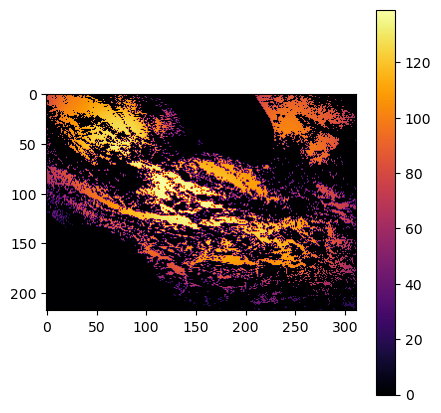

In [12]:
with GeoTiff.from_file(bfsFlowOptimizer.connectivity_fn) as conn:
    conn.draw_geotiff()

In [5]:
# with corridor_hop=1
bfsFlowOptimizer = bfsFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, RESTORED_CONNECTIVITY_PATH, FLOW_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, 50, hab_mat, unrestorable, corridor_hop=1)

bfsFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
permiability_restored = bfsFlowOptimizer.restore()
print(bfsFlowOptimizer.changed_pixels)
bfsFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
print(f"Delta connectivity: {bfsFlowOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Connectivity/permiability_restored: {round(bfsFlowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")
print(f"Connectivity/pixels restored: {round(bfsFlowOptimizer.get_delta_connectivity()/bfsFlowOptimizer.pixels, 2)}")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


{(277, 36): 78, (43, 72): 76, (41, 74): 75, (176, 109): 74, (188, 108): 73, (245, 102): 73, (155, 139): 73, (203, 115): 72, (278, 36): 72, (44, 75): 70, (277, 37): 33, (44, 73): 69, (42, 74): 65, (175, 109): 68, (187, 108): 44, (244, 102): 61, (202, 115): 69, (279, 35): 32, (43, 75): 70, (45, 73): 69, (42, 75): 60, (174, 109): 47, (187, 107): 28, (245, 103): 42, (201, 115): 66, (46, 73): 66, (41, 75): 32, (173, 109): 52, (186, 106): 45, (201, 114): 52, (46, 74): 55, (172, 109): 59, (185, 105): 19, (200, 114): 44, (171, 108): 45, (171, 109): 43, (171, 110): 40, (171, 111): 45, (268, 79): 70, (269, 79): 65, (270, 79): 61, (271, 79): 52, (272, 79): 50, (272, 80): 42, (134, 141): 70, (133, 141): 65, (271, 87): 70, (270, 87): 59, (269, 87): 61, (268, 87): 59}


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 22202
Permiability Restored: 4.990861313868612
Connectivity/permiability_restored: 4448.53
Connectivity/pixels restored: 444.04


In [5]:
TERRAIN_CHANGED_BFS = os.path.join(DATA_PATH, "smol/changed_terrain_flow_bfs.tif")
CONNECTIVITY_DIFF_BFS = os.path.join(DATA_PATH, "smol/connectivity_diff_flow_bfs.tif")

# paint changed terrain pixels
bfsFlowOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED_BFS, value=1)
# view diff of before and after
bfsFlowOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF_BFS)

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


# Greedy Flow Restoration

In [3]:
# limited greedy Flow restoration
greedyFlowOptimizer = greedyFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, PERMEABILITY_PATH, 50, hab_mat, unrestorable, corridor_hop=2)

greedyFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
permiability_restored = greedyFlowOptimizer.restore(verbose=True)
greedyFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
print(f"Delta connectivity: {greedyFlowOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Connectivity/permiability_restored: {round(greedyFlowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")
print(f"Connectivity/pixels restored: {round(greedyFlowOptimizer.get_delta_connectivity()/greedyFlowOptimizer.pixels, 2)}")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (277, 36) from 1402 with permiability 0.9 to 104 with permiability 1.0
Restoring pixel (43, 72) from 1402 with permiability 0.9 to 104 with permiability 1.0
Restoring pixel (41, 74) from 1402 with permiability 0.9 to 104 with permiability 1.0
Restoring pixel (176, 109) from 1402 with permiability 0.9 to 104 with permiability 1.0
Restoring pixel (188, 108) from 1402 with permiability 0.9 to 104 with permiability 1.0
Restoring pixel (245, 102) from 1402 with permiability 0.9 to 104 with permiability 1.0
Restoring pixel (155, 139) from 1403 with permiability 0.9091386861313868 to 104 with permiability 1.0
Restoring pixel (203, 115) from 1402 with permiability 0.9 to 104 with permiability 1.0
Restoring pixel (278, 36) from 1402 with permiability 0.9 to 104 with permiability 1.0
Restoring pixel (44, 75) from 1402 with permiability 0.9 to 104 with permiability 1.0
Restoring pixel (43, 75) from 1402 with permiability 0.9 to 104 with permiability 1.0
Restoring pixel (268, 79) f

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 43665
Permiability Restored: 4.990861313868612
Connectivity/permiability_restored: 8748.99
Connectivity/pixels restored: 873.3


In [8]:
# limited greedy Flow restoration
greedyFlowOptimizer = greedyFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, RESTORED_CONNECTIVITY_PATH, FLOW_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, 50, hab_mat, unrestorable, corridor_hop=2)

greedyFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
permiability_restored = greedyFlowOptimizer.restore(verbose=True)
greedyFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
print(f"Delta connectivity: {greedyFlowOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Connectivity/permiability_restored: {round(greedyFlowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")
print(f"Connectivity/pixels restored: {round(greedyFlowOptimizer.get_delta_connectivity()/greedyFlowOptimizer.pixels, 2)}")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (277, 36) from permiability 0.9 to 1.0
Restoring pixel (43, 72) from permiability 0.9 to 1.0
Restoring pixel (41, 74) from permiability 0.9 to 1.0
Restoring pixel (176, 109) from permiability 0.9 to 1.0
Restoring pixel (188, 108) from permiability 0.9 to 1.0
Restoring pixel (245, 102) from permiability 0.9 to 1.0
Restoring pixel (155, 139) from permiability 0.9091386861313868 to 1.0
Restoring pixel (203, 115) from permiability 0.9 to 1.0
Restoring pixel (278, 36) from permiability 0.9 to 1.0
Restoring pixel (44, 75) from permiability 0.9 to 1.0
Restoring pixel (43, 75) from permiability 0.9 to 1.0
Restoring pixel (268, 79) from permiability 0.9 to 1.0
Restoring pixel (134, 141) from permiability 0.9 to 1.0
Restoring pixel (271, 87) from permiability 0.9 to 1.0
Restoring pixel (11, 115) from permiability 0.9 to 1.0
Restoring pixel (119, 145) from permiability 0.9 to 1.0
Restoring pixel (202, 115) from permiability 0.9 to 1.0
Restoring pixel (204, 113) from permiability 0

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 43938
Permiability Restored: 5.190861313868611
Connectivity/permiability_restored: 8464.49
Connectivity/pixels restored: 878.76


In [4]:
TERRAIN_CHANGED_GREEDY = os.path.join(DATA_PATH, "smol/changed_terrain_flow_greedy_corridor_hop_2.tif")
CONNECTIVITY_DIFF_GREEDY = os.path.join(DATA_PATH, "smol/connectivity_diff_flow_greedy_corridor_hop_2.tif")

# paint changed terrain pixels
greedyFlowOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED_GREEDY, value=1)
# view diff of before and after
greedyFlowOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF_GREEDY)

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


# Flow based restoration

In [50]:
# Flow restoration
flowOptimizer = flowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, 50)

flowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
permiability_restored = flowOptimizer.restore()
flowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
print(f"Delta connectivity: {flowOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Percent connectivity changed: {flowOptimizer.get_connectivity_percent_changed()}%")
print(f"Connectivity/permiability_restored: {round(flowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")
print(f"Connectivity/pixels restored: {round(flowOptimizer.get_delta_connectivity()/flowOptimizer.pixels, 2)}")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 46193
Permiability Restored: 4.990861313868612
Percent connectivity changed: 0.024354995692414113%
Connectivity/permiability_restored: 9255.52


In [4]:
# Flow restoration
flowOptimizer = flowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, 50) #hab_mat, unrestorable)

flowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
permiability_restored = flowOptimizer.restore()
flowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
print(f"Delta connectivity: {flowOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Percent connectivity changed: {flowOptimizer.get_connectivity_percent_changed()}%")
print(f"Connectivity/permiability_restored: {round(flowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")
print(f"Connectivity/pixels restored: {round(flowOptimizer.get_delta_connectivity()/flowOptimizer.pixels, 2)}")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 46193
Permiability Restored: 4.990861313868612
Percent connectivity changed: 0.024354995692414113%
Connectivity/permiability_restored: 9255.52
Connectivity/pixels restored: 923.86


# Low Res Flow

In [71]:
lowResFlowOptimizer = lowResFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, RESTORED_CONNECTIVITY_PATH, FLOW_PATH, RESTORED_FLOW_PATH, DEATH_PATH, LOW_RES_FLOW_PATH, PERMEABILITY_PATH, 2, 2, 50, percent_impermiable=0.75)

lowResFlowOptimizer.run_connectivity(gap_crossing=4, num_gaps=40)
permiability_restored = lowResFlowOptimizer.restore()
lowResFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=False)
lowResFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
print(f"Delta connectivity: {lowResFlowOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Percent connectivity changed: {lowResFlowOptimizer.get_connectivity_percent_changed()}%")
print(f"Connectivity/permiability_restored: {lowResFlowOptimizer.get_delta_connectivity()/permiability_restored}")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


[(42, 72), (42, 73), (43, 72), (43, 73), (44, 74), (44, 75), (45, 74), (45, 75), (46, 74), (46, 75), (47, 74), (47, 75), (262, 76), (262, 77), (263, 76), (263, 77), (268, 76), (268, 77), (269, 76), (269, 77), (42, 74), (42, 75), (43, 74), (43, 75), (28, 68), (28, 69), (29, 68), (29, 69), (32, 64), (32, 65), (33, 64), (33, 65), (266, 76), (266, 77), (267, 76), (267, 77), (210, 54), (210, 55), (211, 54), (211, 55), (40, 72), (40, 73), (41, 72), (41, 73), (214, 50), (214, 51), (215, 50), (215, 51), (48, 73), (49, 72), (49, 73)]


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 1842
Permiability Restored: 5.099999999999998
Percent connectivity changed: 0.0006965442029522584%
Connectivity/permiability_restored: 361.1764705882354


In [4]:
lowResFlowOptimizer = lowResFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, RESTORED_CONNECTIVITY_PATH, FLOW_PATH, RESTORED_FLOW_PATH, DEATH_PATH, LOW_RES_FLOW_PATH, PERMEABILITY_PATH, 2, 2, 50, percent_impermiable=0.75)

lowResFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
permiability_restored = lowResFlowOptimizer.restore()
lowResFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
print(f"Delta connectivity: {lowResFlowOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Percent connectivity changed: {lowResFlowOptimizer.get_connectivity_percent_changed()}%")
print(f"Connectivity/permiability_restored: {lowResFlowOptimizer.get_delta_connectivity()/permiability_restored}")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 22059
Permiability Restored: 5.190861313868611
Percent connectivity changed: 0.01163048189074022%
Connectivity/permiability_restored: 4249.583771591851


In [6]:
TERRAIN_CHANGED_UTOPIAN = os.path.join(DATA_PATH, "smol/changed_terrain_flow_low_res.tif")
CONNECTIVITY_DIFF_UTOPIAN = os.path.join(DATA_PATH, "smol/connectivity_diff_flow_low_res.tif")

# paint changed terrain pixels
lowResFlowOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED_UTOPIAN, value=1)
# view diff of before and after
lowResFlowOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF_UTOPIAN)

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [67]:
TERRAIN_CHANGED_UTOPIAN = os.path.join(DATA_PATH, "smol/changed_terrain_flow_low_res.tif")
CONNECTIVITY_DIFF_UTOPIAN = os.path.join(DATA_PATH, "smol/connectivity_diff_flow_low_res.tif")

def get_connectivity_difference_tif(flowOptimizer, connectivity_diff_fn):
    # get origional connectivity
    with GeoTiff.from_file(flowOptimizer.connectivity_fn) as connectivity_tif:
        connectivity_tile = connectivity_tif.get_all_as_tile()
        # create connectivity diff tif from clone of connectivity_tif
        connectivity_tif.clone_shape(connectivity_diff_fn, dtype='int16')

    # get restored connectivity
    with GeoTiff.from_file(flowOptimizer.restored_connectivity_fn) as restored_connectivity_tif:
        restored_connectivity_tile = restored_connectivity_tif.get_all_as_tile()

    # get the difference of the two in a tile
    diff = Tile(connectivity_tile.w, connectivity_tile.h, connectivity_tile.b, connectivity_tile.c, connectivity_tile.x, connectivity_tile.y, (restored_connectivity_tile.m.astype('int16') - connectivity_tile.m.astype('int16')))
    # write the tile to connectivity diff tif
    with GeoTiff.from_file(connectivity_diff_fn) as connectivity_diff:
        connectivity_diff.set_tile(diff)


# paint changed terrain pixels
lowResFlowOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED_UTOPIAN, flowOptimizer.changed_pixels, value=1)
# view diff of before and after
get_connectivity_difference_tif(lowResFlowOptimizer, CONNECTIVITY_DIFF_UTOPIAN)

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [74]:
DATA_PATH="/Users/nvalett/Documents/Natalie/Species Dist Research/Thesis/EcoLinker/tests/assets"
HABITAT_PATH = os.path.join(DATA_PATH, "smol_fragmented/habitat.tif")
TERRAIN_PATH = os.path.join(DATA_PATH, "smol_fragmented/terrain.tif")
RESTORED_TERRAIN_PATH = os.path.join(DATA_PATH, "smol_fragmented/restored_ter_smol.tif")
PERMEABILITY_PATH = os.path.join(DATA_PATH, "paper_repro/transmission_refined_1.csv")

CONNECTIVITY_PATH = os.path.join(DATA_PATH, "smol_fragmented/repop.tif")
RESTORED_CONNECTIVITY_PATH = os.path.join(DATA_PATH, "smol_fragmented/repop_after_restoration.tif")
FLOW_PATH = os.path.join(DATA_PATH, "smol_fragmented/grad.tif")
RESTORED_FLOW_PATH = os.path.join(DATA_PATH, "smol_fragmented/grad_after_restoration.tif")
LOW_RES_FLOW_PATH = os.path.join(DATA_PATH, "smol_fragmented/flow_low_res.tif")

unrestorable = [104,500, 501, 502, 503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,900, 901, 902, 903, 904, 905, 906,907,980,981,982,983,984,985,986,909,910,1000,1001,1002,1003,1004,1100,1101,1111,1112,1102,1103,1104,1105,1106,1200,1201,1202,1203,1204,1205,1206,1207,1300,1301,1302,1303,1304,1305,    1402]

with GeoTiff.from_file(HABITAT_PATH) as hab:
    hab_mat = hab.get_all_as_tile().m.squeeze(0)

flowOptimizer = flowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, 50, hab_mat, unrestorable)
lowResFlowOptimizer = lowResFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, RESTORED_CONNECTIVITY_PATH, FLOW_PATH, RESTORED_FLOW_PATH, DEATH_PATH, LOW_RES_FLOW_PATH, PERMEABILITY_PATH, 2, 2, 50)

In [75]:
flowOptimizer = flowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, 50) #hab_mat, unrestorable)

results = {}
for gap_crossing in [2,3,4,5]:
    for num_gaps in [20,40,60,80]:
        flowOptimizer.run_connectivity(gap_crossing=gap_crossing, num_gaps=num_gaps)
        permiability_restored = flowOptimizer.restore()
        flowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=False)
        flowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
        print(f"Delta connectivity: {flowOptimizer.get_delta_connectivity()}")
        print(f"Permiability Restored: {permiability_restored}")
        print(f"Percent connectivity changed: {flowOptimizer.get_connectivity_percent_changed()}%")
        print(f"Connectivity/permiability_restored: {flowOptimizer.get_delta_connectivity()/permiability_restored}")
        results[(gap_crossing, num_gaps)] = flowOptimizer.get_delta_connectivity()/permiability_restored

        TERRAIN_CHANGED_UTOPIAN = os.path.join(DATA_PATH, f"smol_fragmented/changed_terrain_flow_low_res_{gap_crossing}_{num_gaps}.tif")
        CONNECTIVITY_DIFF_UTOPIAN = os.path.join(DATA_PATH, f"smol_fragmented/connectivity_diff_flow_low_res_{gap_crossing}_{num_gaps}.tif")

        # paint changed terrain pixels
        flowOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED_UTOPIAN, value=1)
        # view diff of before and after
        flowOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF_UTOPIAN)
print(results)

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 32602
Permiability Restored: 4.936029197080292
Percent connectivity changed: 0.0009304348014693804%
Connectivity/permiability_restored: 6604.904205040843


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 32602
Permiability Restored: 4.936029197080292
Percent connectivity changed: 0.0009304348014693804%
Connectivity/permiability_restored: 6604.904205040843


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 32602
Permiability Restored: 4.936029197080292
Percent connectivity changed: 0.0009304348014693804%
Connectivity/permiability_restored: 6604.904205040843


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 32602
Permiability Restored: 4.936029197080292
Percent connectivity changed: 0.0009304348014693804%
Connectivity/permiability_restored: 6604.904205040843


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 3806
Permiability Restored: 4.9634452554744515
Percent connectivity changed: 0.00010862017221006262%
Connectivity/permiability_restored: 766.8060800715305


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 3806
Permiability Restored: 4.9634452554744515
Percent connectivity changed: 0.00010862017221006262%
Connectivity/permiability_restored: 766.8060800715305


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 3806
Permiability Restored: 4.9634452554744515
Percent connectivity changed: 0.00010862017221006262%
Connectivity/permiability_restored: 766.8060800715305


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 3806
Permiability Restored: 4.9634452554744515
Percent connectivity changed: 0.00010862017221006262%
Connectivity/permiability_restored: 766.8060800715305


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 770
Permiability Restored: 4.945167883211678
Percent connectivity changed: 2.19751793488566e-05%
Connectivity/permiability_restored: 155.70755496776331


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 770
Permiability Restored: 4.945167883211678
Percent connectivity changed: 2.19751793488566e-05%
Connectivity/permiability_restored: 155.70755496776331


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 770
Permiability Restored: 4.945167883211678
Percent connectivity changed: 2.19751793488566e-05%
Connectivity/permiability_restored: 155.70755496776331


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 770
Permiability Restored: 4.945167883211678
Percent connectivity changed: 2.19751793488566e-05%
Connectivity/permiability_restored: 155.70755496776331


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


KeyboardInterrupt: 

In [22]:
# Flow restoration
flowOptimizer = flowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, 50) #hab_mat, unrestorable)

# flowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
permiability_restored = flowOptimizer.restore()
flowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
print(f"Delta connectivity: {flowOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Percent connectivity changed: {flowOptimizer.get_connectivity_percent_changed()}%")
print(f"Connectivity/permiability_restored: {round(flowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 32602
Permiability Restored: 4.936029197080292
Percent connectivity changed: 0.0009304348014693804%
Connectivity/permiability_restored: 6604.9


In [ ]:
# Flow restoration
flowOptimizer = flowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, 50) #hab_mat, unrestorable)

flowOptimizer.run_connectivity(gap_crossing=3, num_gaps=50)
permiability_restored = flowOptimizer.restore()
flowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
print(f"Delta connectivity: {flowOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Percent connectivity changed: {flowOptimizer.get_connectivity_percent_changed()}%")
print(f"Connectivity/permiability_restored: {round(flowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")

In [25]:
print(len(flowOptimizer.changed_pixels))
print(flowOptimizer.changed_pixels)

50
{(360, 460): 80, (598, 75): 79, (574, 138): 76, (568, 658): 76, (570, 656): 75, (564, 1067): 75, (584, 1090): 74, (575, 1092): 71, (574, 1090): 71, (621, 111): 70, (539, 159): 70, (581, 138): 70, (582, 660): 70, (492, 735): 69, (346, 425): 69, (493, 732): 69, (579, 69): 69, (586, 75): 69, (452, 413): 69, (558, 656): 68, (581, 815): 68, (583, 153): 68, (545, 101): 68, (620, 109): 68, (570, 1069): 68, (592, 1074): 68, (590, 1075): 68, (591, 1075): 68, (583, 1090): 68, (471, 287): 67, (582, 153): 67, (606, 665): 67, (503, 753): 67, (452, 414): 67, (472, 284): 67, (663, 462): 67, (614, 114): 67, (462, 1127): 66, (590, 1077): 66, (566, 773): 66, (598, 1071): 66, (562, 772): 66, (447, 1024): 66, (517, 654): 66, (320, 423): 66, (523, 855): 66, (556, 130): 66, (635, 893): 65, (613, 114): 65, (677, 622): 65}


In [23]:
TERRAIN_CHANGED_UTOPIAN = os.path.join(DATA_PATH, "smol_fragmented/changed_terrain_flow.tif")
CONNECTIVITY_DIFF_UTOPIAN = os.path.join(DATA_PATH, "smol_fragmented/connectivity_diff_flow.tif")

# paint changed terrain pixels
flowOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED_UTOPIAN, value=1)
# view diff of before and after
flowOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF_UTOPIAN)

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [26]:
# low res with factor of 2
lowResFlowOptimizer = lowResFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, RESTORED_CONNECTIVITY_PATH, FLOW_PATH, RESTORED_FLOW_PATH, DEATH_PATH, LOW_RES_FLOW_PATH, PERMEABILITY_PATH, 2, 2, 50, percent_impermiable=0.75)

lowResFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
permiability_restored = lowResFlowOptimizer.restore()
lowResFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
print(f"Delta connectivity: {lowResFlowOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Percent connectivity changed: {lowResFlowOptimizer.get_connectivity_percent_changed()}%")
print(f"Connectivity/permiability_restored: {lowResFlowOptimizer.get_delta_connectivity()/permiability_restored}")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


[(740, 668), (740, 669), (741, 668), (741, 669), (592, 692), (592, 693), (593, 692), (593, 693), (286, 834), (286, 835), (287, 834), (108, 1130), (108, 1131), (109, 1130), (109, 1131), (64, 1122), (65, 1122), (65, 1123), (72, 1114), (72, 1115), (73, 1114), (73, 1115), (92, 1090), (92, 1091), (93, 1090), (93, 1091), (506, 968), (506, 969), (507, 968), (507, 969), (590, 1075), (591, 1074), (591, 1075), (610, 1140), (610, 1141), (611, 1140), (611, 1141), (222, 818), (222, 819), (223, 818), (223, 819), (490, 746), (490, 747), (491, 746), (491, 747), (570, 660), (570, 661), (571, 660), (571, 661), (408, 470), (408, 471), (409, 470)]


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 11605
Permiability Restored: 5.512934306569342
Percent connectivity changed: 0.0003311973459006245%
Connectivity/permiability_restored: 2105.049571545086


In [27]:
TERRAIN_CHANGED_UTOPIAN = os.path.join(DATA_PATH, "smol_fragmented/changed_terrain_flow_low_res_2_2.tif")
CONNECTIVITY_DIFF_UTOPIAN = os.path.join(DATA_PATH, "smol_fragmented/connectivity_diff_flow_low_res_2_2.tif")

# paint changed terrain pixels
lowResFlowOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED_UTOPIAN, value=1)
# view diff of before and after
lowResFlowOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF_UTOPIAN)

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [29]:
# low res with factor of 4
lowResFlowOptimizer = lowResFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, RESTORED_CONNECTIVITY_PATH, FLOW_PATH, RESTORED_FLOW_PATH, DEATH_PATH, LOW_RES_FLOW_PATH, PERMEABILITY_PATH, 4, 4, 50, percent_impermiable=0.75)

# lowResFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
permiability_restored = lowResFlowOptimizer.restore()
lowResFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
print(f"Delta connectivity: {lowResFlowOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Percent connectivity changed: {lowResFlowOptimizer.get_connectivity_percent_changed()}%")
print(f"Connectivity/permiability_restored: {lowResFlowOptimizer.get_delta_connectivity()/permiability_restored}")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


[(220, 816), (220, 819), (221, 818), (221, 819), (222, 816), (222, 817), (222, 818), (222, 819), (223, 816), (223, 817), (223, 818), (223, 819), (492, 732), (492, 733), (492, 734), (492, 735), (493, 732), (493, 733), (493, 734), (493, 735), (494, 732), (494, 733), (494, 735), (495, 732), (495, 733), (495, 735), (400, 369), (400, 370), (400, 371), (401, 368), (401, 369), (401, 370), (402, 368), (402, 369), (402, 370), (403, 368), (403, 369), (403, 370), (64, 1120), (64, 1121), (64, 1122), (65, 1121), (65, 1122), (65, 1123), (66, 1120), (66, 1121), (66, 1122), (66, 1123), (67, 1122), (67, 1123)]


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 4999
Permiability Restored: 7.3780145985401475
Percent connectivity changed: 0.00014266743060381058%
Connectivity/permiability_restored: 677.5535522780245


In [32]:
# low res with factor of 4
lowResFlowOptimizer = lowResFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, RESTORED_CONNECTIVITY_PATH, FLOW_PATH, RESTORED_FLOW_PATH, DEATH_PATH, LOW_RES_FLOW_PATH, PERMEABILITY_PATH, 4, 4, 50, percent_impermiable=0.25)

# lowResFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
permiability_restored = lowResFlowOptimizer.restore()
lowResFlowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
print(f"Delta connectivity: {lowResFlowOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Percent connectivity changed: {lowResFlowOptimizer.get_connectivity_percent_changed()}%")
print(f"Connectivity/permiability_restored: {lowResFlowOptimizer.get_delta_connectivity()/permiability_restored}")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


[(601, 372), (601, 373), (602, 372), (602, 373), (412, 479), (414, 477), (415, 477), (415, 479), (254, 900), (254, 901), (255, 900), (255, 901), (212, 846), (212, 847), (213, 845), (213, 847), (202, 862), (202, 863), (203, 862), (203, 863), (132, 1064), (132, 1067), (133, 1067), (135, 1066), (174, 933), (174, 934), (175, 932), (175, 933), (256, 915), (257, 915), (258, 915), (259, 914), (588, 1075), (590, 1075), (591, 1073), (591, 1074), (591, 1075), (614, 378), (614, 379), (615, 378), (615, 379), (164, 992), (164, 993), (166, 993), (166, 995), (161, 1149), (162, 1148), (162, 1149), (162, 1150), (597, 374), (597, 375), (598, 372), (599, 372)]


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


KeyboardInterrupt: 

In [30]:
TERRAIN_CHANGED_UTOPIAN = os.path.join(DATA_PATH, "smol_fragmented/changed_terrain_flow_low_res_4_4.tif")
CONNECTIVITY_DIFF_UTOPIAN = os.path.join(DATA_PATH, "smol_fragmented/connectivity_diff_flow_low_res_4_4.tif")

# paint changed terrain pixels
lowResFlowOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED_UTOPIAN, value=1)
# view diff of before and after
lowResFlowOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF_UTOPIAN)

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [7]:
def get_greedy_flow_pixels(optimizer, flow, n=None):
    if (n == None):
        n = optimizer.pixels
    flow = flow.squeeze(0)
    total_px = flow.shape[0] * flow.shape[1]
    flat_indices = np.argpartition(flow.ravel(), -total_px)[-total_px:]
    row_indices, col_indices = np.unravel_index(flat_indices, flow.shape)

    min_elements = flow[row_indices, col_indices]
    min_elements_order = np.argsort(min_elements)
    row_indices, col_indices = row_indices[min_elements_order], col_indices[min_elements_order]

    highest_flow = {}
    with GeoTiff.from_file(optimizer.terrain_fn) as terr:
        raw_terrain = terr.get_all_as_tile().m.squeeze(0)
    with GeoTiff.from_file(optimizer.habitat_fn) as hab:
        raw_hab = hab.get_all_as_tile().m.squeeze(0)

    i = total_px
    while (len(highest_flow.items()) < n and i > 0):
        stack = [(col_indices[i-1], row_indices[i-1])]
        while len(stack) > 0:
            col, row = stack.pop()
            terrain = raw_terrain[row][col]
            permiability = optimizer.permeability_dict[terrain]
            if permiability < 1 and raw_hab[row][col] != 1:
                highest_flow[(col, row)] = flow[row][col]
                # find highest grad of neighbors and push to stack
                max_neighbor = ()
                max_neighbor_flow = 0
                for neighbor_col, neighbor_row in [(col - 1, row), (col + 1, row), (col, row - 1), (col, row + 1), (col - 1, row - 1), (col + 1, row + 1), (col - 1, row + 1), (col + 1, row - 1)]:
                    if neighbor_col >= 0 and neighbor_col < flow.shape[1] and neighbor_row >= 0 and neighbor_row < flow.shape[0]:
                        neighbor_flow = flow[neighbor_row][neighbor_col]
                        if neighbor_flow > max_neighbor_flow and (neighbor_col, neighbor_row) not in highest_flow:
                            max_neighbor = (neighbor_col, neighbor_row)
                            max_neighbor_flow = neighbor_flow
                if max_neighbor_flow > 0:
                    stack.append(max_neighbor)
            else:
                break
        i -= 1
    return highest_flow

with GeoTiff.from_file(flowOptimizer.flow_fn) as flow_tif:
    flow = flow_tif.get_all_as_tile().m

highest_flow = get_greedy_flow_pixels(flowOptimizer, flow)
print(highest_flow)

{(307, 52): 0, (3, 53): 0, (2, 53): 0, (1, 53): 0, (8, 199): 0, (311, 52): 0, (310, 52): 0, (309, 52): 0, (308, 52): 0, (309, 158): 0, (4, 53): 0, (305, 52): 0, (304, 52): 0, (303, 52): 0, (302, 52): 0, (301, 52): 0, (300, 52): 0, (299, 52): 0, (298, 52): 0, (297, 52): 0, (306, 52): 0, (6, 53): 0, (5, 53): 0, (18, 53): 0, (3, 199): 0, (4, 199): 0, (5, 199): 0, (6, 199): 0, (7, 199): 0, (22, 53): 0, (21, 53): 0, (20, 53): 0, (19, 53): 0, (17, 53): 0, (7, 53): 0, (16, 53): 0, (15, 53): 0, (14, 53): 0, (13, 53): 0, (12, 53): 0, (11, 53): 0, (10, 53): 0, (9, 53): 0, (8, 53): 0, (296, 52): 0, (295, 52): 0, (29, 53): 0, (294, 52): 0, (30, 199): 0, (31, 199): 0, (32, 199): 0, (33, 199): 0, (34, 199): 0, (264, 52): 0, (263, 52): 0, (35, 199): 0, (36, 199): 0, (260, 52): 0, (259, 52): 0, (258, 52): 0, (257, 52): 0, (256, 52): 0, (255, 52): 0, (254, 52): 0, (253, 52): 0, (252, 52): 0, (251, 52): 0, (250, 52): 0, (249, 52): 0, (29, 199): 0, (28, 199): 0, (27, 199): 0, (15, 199): 0, (293, 52): 0, 

In [ ]:
def get_greedy_flow_pixels(self, flow, n=None):
    if (n == None):
        n = self.pixels
    flow = flow.squeeze(0)
    total_px = flow.shape[0] * flow.shape[1]
    flat_indices = np.argpartition(flow.ravel(), -total_px)[-total_px:]
    row_indices, col_indices = np.unravel_index(flat_indices, flow.shape)

    min_elements = flow[row_indices, col_indices]
    min_elements_order = np.argsort(min_elements)
    row_indices, col_indices = row_indices[min_elements_order], col_indices[min_elements_order]

    highest_flow = {}
    with GeoTiff.from_file(self.terrain_fn) as terr:
        raw_terrain = terr.get_all_as_tile().m.squeeze(0)
    with GeoTiff.from_file(self.habitat_fn) as hab:
        raw_hab = hab.get_all_as_tile().m.squeeze(0)

    i = total_px
    while (len(highest_flow.items()) < n and i > 0):
        stack = [(col_indices[i-1], row_indices[i-1])]
        while len(stack) > 0:
            col, row = stack.pop()
            terrain = raw_terrain[row][col]
            permiability = self.permeability_dict[terrain]
            if permiability < 1 and raw_hab[row][col] != 1:
                highest_flow[(col, row)] = flow[row][col]
                # find highest grad of neighbors and push to stack
                max_neighbor = ()
                max_neighbor_flow = 0
                for neighbor_col, neighbor_row in [(col - 1, row), (col + 1, row), (col, row - 1), (col, row + 1), (col - 1, row - 1), (col + 1, row + 1), (col - 1, row + 1), (col + 1, row - 1)]:
                    neighbor_flow = flow[neighbor_row][neighbor_col]
                    if neighbor_flow > max_neighbor_flow and (neighbor_col, neighbor_row) not in highest_flow:
                        max_neighbor = (neighbor_col, neighbor_row)
                        max_neighbor_flow = neighbor_flow
                stack.append(max_neighbor)
            else:
                break
        i -= 1
    return highest_flow

In [28]:
TERRAIN_CHANGED_GREEDY = os.path.join(DATA_PATH, "smol/changed_terrain_flow_greedy.tif")

flowOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED_GREEDY, highest_flow, value=1)

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

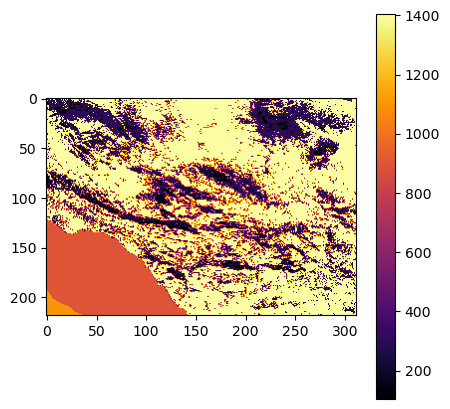

<Figure size 500x500 with 0 Axes>

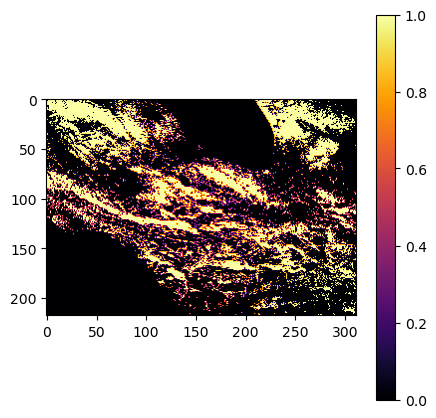

{(277, 36): 78, (43, 72): 76, (41, 74): 75, (176, 109): 74, (188, 108): 73, (245, 102): 73, (155, 139): 73, (203, 115): 72, (278, 36): 72, (44, 75): 70, (43, 75): 70, (268, 79): 70, (134, 141): 70, (271, 87): 70, (11, 115): 69, (119, 145): 69, (202, 115): 69, (103, 117): 69, (45, 73): 69, (44, 73): 69, (41, 85): 69, (203, 109): 69, (109, 141): 68, (199, 159): 68, (267, 75): 68, (27, 70): 68, (175, 109): 68, (202, 109): 68, (204, 109): 68, (109, 142): 67, (163, 105): 67, (245, 122): 67, (246, 122): 67, (89, 132): 67, (29, 68): 67, (216, 114): 67, (33, 64): 67, (31, 66): 67, (152, 138): 66, (134, 62): 66, (118, 145): 66, (277, 118): 66, (201, 115): 66, (220, 198): 66, (46, 73): 66, (128, 56): 66, (269, 83): 66, (120, 49): 65, (136, 64): 65, (133, 141): 65}


In [45]:
# starting from working version
flowOptimizer = flowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, 50, hab_mat, unrestorable)

def get_greedy_flow_pixels(optimizer, flow, n=None):
    if (n == None):
        n = optimizer.pixels
    flow = flow.squeeze(0)
    total_px = flow.shape[0] * flow.shape[1]
    flat_indices = np.argpartition(flow.ravel(), -total_px)[-total_px:]
    row_indices, col_indices = np.unravel_index(flat_indices, flow.shape)

    min_elements = flow[row_indices, col_indices]
    min_elements_order = np.argsort(min_elements)
    row_indices, col_indices = row_indices[min_elements_order], col_indices[min_elements_order]

    highest_flow = {}
    with GeoTiff.from_file(optimizer.terrain_fn) as terr:
        raw_terrain = terr.get_all_as_tile().m.squeeze(0)
        terr.draw_geotiff()
    with GeoTiff.from_file(optimizer.habitat_fn) as hab:
        raw_hab = hab.get_all_as_tile().m.squeeze(0)
        hab.draw_geotiff()

    i = total_px
    while (len(highest_flow.items()) < n and i > 0):
        stack = [(col_indices[i-1], row_indices[i-1])]
        col, row = col_indices[i-1], row_indices[i-1]
        # while len(stack) > 0:
        #     print(stack)
        #     col, row = stack.pop()
        terrain = raw_terrain[row][col]
        permiability = optimizer.permeability_dict[terrain]
        if permiability < 1: #and raw_hab[row][col] != 1:
            highest_flow[(col, row)] = flow[row][col]
        #         # find highest grad of neighbors and push to stack
        #         max_neighbor = ()
        #         max_neighbor_flow = 0
        #         for neighbor_col, neighbor_row in [(col - 1, row), (col + 1, row), (col, row - 1), (col, row + 1), (col - 1, row - 1), (col + 1, row + 1), (col - 1, row + 1), (col + 1, row - 1)]:
        #             if neighbor_col >= 0 and neighbor_col < flow.shape[1] and neighbor_row >= 0 and neighbor_row < flow.shape[0]:
        #                 neighbor_flow = flow[neighbor_row][neighbor_col]
        #                 if neighbor_flow > max_neighbor_flow and (neighbor_col, neighbor_row) not in highest_flow:
        #                     print(neighbor_flow)
                            
        #                     max_neighbor = (neighbor_col, neighbor_row)
        #                     max_neighbor_flow = neighbor_flow
        #         if max_neighbor_flow > 0:
        #             stack.append(max_neighbor)
        #     else:
        #         break
        i -= 1
    return highest_flow

with GeoTiff.from_file(flowOptimizer.habitat_fn) as hab:
    hab_m = hab.get_all_as_tile().m
with GeoTiff.from_file(flowOptimizer.flow_fn) as flow_tif:
    flow = flow_tif.get_all_as_tile().m

# flowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
highest_flow = get_greedy_flow_pixels(flowOptimizer, flow)
print(highest_flow)

In [ ]:
# starting from working version
flowOptimizer = flowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, 100, hab_mat, unrestorable)

def get_greedy_flow_pixels(optimizer, flow, n=None, number_corridors=None):
    if (n == None):
        n = optimizer.pixels
    flow = flow.squeeze(0)
    total_px = flow.shape[0] * flow.shape[1]
    flat_indices = np.argpartition(flow.ravel(), -total_px)[-total_px:]
    row_indices, col_indices = np.unravel_index(flat_indices, flow.shape)

    min_elements = flow[row_indices, col_indices]
    min_elements_order = np.argsort(min_elements)
    row_indices, col_indices = row_indices[min_elements_order], col_indices[min_elements_order]

    highest_flow = {}
    with GeoTiff.from_file(optimizer.terrain_fn) as terr:
        raw_terrain = terr.get_all_as_tile().m.squeeze(0)
        terr.draw_geotiff()
    with GeoTiff.from_file(optimizer.habitat_fn) as hab:
        raw_hab = hab.get_all_as_tile().m.squeeze(0)
        hab.draw_geotiff()

    i = total_px
    stack = []
    seen = []
    while len(stack) < number_corridors:
        terrain = raw_terrain[row_indices[i-1]][col_indices[i-1]]
        permiability = optimizer.permeability_dict[terrain]
        if permiability < 1 and raw_hab[row_indices[i-1]][col_indices[i-1]] != 1:
            stack.append((col_indices[i-1], row_indices[i-1]))
        i -= 1
    while (len(highest_flow.items()) < n and len(stack) > 0):
        while len(stack) > 0:
            print(stack)
            col, row = stack.pop()
            terrain = raw_terrain[row][col]
            permiability = optimizer.permeability_dict[terrain]
            if permiability < 1 and raw_hab[row][col] != 1: # on start-up, has the propensity to not register raw_hab[row][col] != 1 as true
                highest_flow[(col, row)] = flow[row][col]
                # find highest grad of neighbors and push to stack
                max_neighbor = ()
                max_neighbor_flow = 0
                for neighbor_col, neighbor_row in [(col - 1, row), (col + 1, row), (col, row - 1), (col, row + 1), (col - 1, row - 1), (col + 1, row + 1), (col - 1, row + 1), (col + 1, row - 1)]:
                    if neighbor_col >= 0 and neighbor_col < flow.shape[1] and neighbor_row >= 0 and neighbor_row < flow.shape[0]:
                        neighbor_flow = flow[neighbor_row][neighbor_col]
                        if neighbor_flow > max_neighbor_flow and (neighbor_col, neighbor_row) not in highest_flow:
                            max_neighbor = (neighbor_col, neighbor_row)
                            max_neighbor_flow = neighbor_flow
                if max_neighbor_flow > 0:
                    stack.append(max_neighbor)
            else:
                break
        i -= 1
    return highest_flow

with GeoTiff.from_file(flowOptimizer.habitat_fn) as hab:
    hab_m = hab.get_all_as_tile().m
with GeoTiff.from_file(flowOptimizer.flow_fn) as flow_tif:
    flow = flow_tif.get_all_as_tile().m

# flowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
highest_flow = get_greedy_flow_pixels(flowOptimizer, flow)
print(highest_flow)

In [14]:
flowOptimizer = flowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, 50, hab_mat, unrestorable)

def get_bfs_flow_pixels(optimizer, flow, n=None, number_corridors=None):
    if (n == None):
        n = optimizer.pixels
    if (number_corridors == None):
        number_corridors = n / 5
    flow = flow.squeeze(0)
    total_px = flow.shape[0] * flow.shape[1]
    flat_indices = np.argpartition(flow.ravel(), -total_px)[-total_px:]
    row_indices, col_indices = np.unravel_index(flat_indices, flow.shape)

    min_elements = flow[row_indices, col_indices]
    min_elements_order = np.argsort(min_elements)
    row_indices, col_indices = row_indices[min_elements_order], col_indices[min_elements_order]

    highest_flow = {}
    with GeoTiff.from_file(optimizer.terrain_fn) as terr:
        raw_terrain = terr.get_all_as_tile().m.squeeze(0)
    with GeoTiff.from_file(optimizer.habitat_fn) as hab:
        raw_hab = hab.get_all_as_tile().m.squeeze(0)

    i = total_px
    stack = []
    seen = []
    while len(stack) < number_corridors:
        print(flow[row_indices[i-1]][col_indices[i-1]])
        terrain = raw_terrain[row_indices[i-1]][col_indices[i-1]]
        permiability = optimizer.permeability_dict[terrain]
        if permiability < 1 and raw_hab[row_indices[i-1]][col_indices[i-1]] != 1:
            stack.append((col_indices[i-1], row_indices[i-1]))
        i -= 1
    while (len(highest_flow.items()) < n and len(stack) > 0):
        col, row = stack.pop(0)
        seen.append((col, row))
        terrain = raw_terrain[row][col]
        permiability = optimizer.permeability_dict[terrain]
        if permiability < 1 and raw_hab[row][col] != 1:
            highest_flow[(col, row)] = flow[row][col]
            # find highest grad of neighbors and push to stack
            max_neighbor = ()
            max_neighbor_flow = 0
            for neighbor_col, neighbor_row in [(col - 1, row), (col + 1, row), (col, row - 1), (col, row + 1), (col - 1, row - 1), (col + 1, row + 1), (col - 1, row + 1), (col + 1, row - 1)]:
                if neighbor_col >= 0 and neighbor_col < flow.shape[1] and neighbor_row >= 0 and neighbor_row < flow.shape[0]:
                    neighbor_flow = flow[neighbor_row][neighbor_col]
                    if neighbor_flow > max_neighbor_flow and (neighbor_col, neighbor_row) not in highest_flow and (neighbor_col, neighbor_row) not in seen and (neighbor_col, neighbor_row) not in stack and optimizer.permeability_dict[raw_terrain[row][col]] < 1 and raw_hab[row][col] != 1: 
                        # limited neighbors in highest_flow
                        neighbors_of_neighbors_in_highest_flow = [x for x in [(neighbor_col - 1, neighbor_row), (neighbor_col + 1, neighbor_row), (neighbor_col, neighbor_row - 1), (neighbor_col, neighbor_row + 1), (neighbor_col - 1, neighbor_row - 1), (neighbor_col + 1, neighbor_row + 1), (neighbor_col - 1, neighbor_row + 1), (neighbor_col + 1, neighbor_row - 1)] if x in highest_flow]
                        if len(neighbors_of_neighbors_in_highest_flow) > 3:
                            break
                        max_neighbor = (neighbor_col, neighbor_row)
                        max_neighbor_flow = neighbor_flow
            if max_neighbor_flow > 0:
                stack.append(max_neighbor)
            else:
                stack.append((col_indices[i-1], row_indices[i-1]))
                i -= 1
        # else:
        #     stack.append((col_indices[i-1], row_indices[i-1]))
        #     i -= 1
    return highest_flow

with GeoTiff.from_file(flowOptimizer.flow_fn) as flow_tif:
    flow = flow_tif.get_all_as_tile().m

# flowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
highest_flow = get_bfs_flow_pixels(flowOptimizer, flow)
print(highest_flow)

140
140
140
140
140
140
140
140
140
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138


In [42]:
print(len(highest_flow))

100


In [11]:
TERRAIN_CHANGED_GREEDY = os.path.join(DATA_PATH, "smol/changed_terrain_flow_bfs.tif")

flowOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED_GREEDY, highest_flow, value=1)

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
